### Exploring dataset categories

In [1]:
#!pip install -U sentence-transformers

In [2]:
import pandas as pd
import numpy as np
#from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from tqdm.notebook import tqdm
import warnings
from sentence_transformers import SentenceTransformer

warnings.filterwarnings('ignore')

# Check if CUDA is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [3]:
df_chats = pd.read_csv("unique_chats.csv")

In [4]:
print(df_chats.shape)

(1861615, 5)


In [5]:
print("1% of the dataset:")
int(df_chats.shape[0] * 0.01)

1% of the dataset:


18616

### SUBSAMPLING

In [6]:
# Vamos amostrar ~ 2% do dataset
SAMPLE_SIZE = 40000

df_chats = df_chats.sample(n=SAMPLE_SIZE, random_state=42)

In [7]:
df_chats.dropna(subset=['content'], inplace=True)
df_chats.shape

(39999, 5)

In [8]:
# tfidf = TfidfVectorizer(
#     stop_words=None, 
#     ngram_range=(1, 3),  # Include unigrams, bigrams and trigrams
#     min_df=10,  # Ignore terms that appear in less than 2 documents
#     max_df=0.95,  # Ignore terms that appear in more than 95% of documents
# )

sentences = df_chats['content'].tolist()

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

embedding_matrix = model.encode(
    sentences,
    batch_size=32,  # Adjust for low GPU memory
    show_progress_bar=True,
    convert_to_numpy=True,   # Returns numpy array
    normalize_embeddings=False  # Set to True for L2 normalized embeddings
)

embedding_matrix

Batches:   0%|          | 0/1250 [00:00<?, ?it/s]

array([[ 0.0268426 ,  0.1267092 ,  0.00842397, ...,  0.06011191,
        -0.02478361, -0.03037691],
       [-0.06839691,  0.03205678,  0.02073552, ..., -0.00582189,
         0.00377361, -0.02820321],
       [ 0.02497119,  0.11722032, -0.01637275, ...,  0.03750918,
         0.01187344, -0.03680269],
       ...,
       [ 0.04263622,  0.0746923 , -0.0374469 , ...,  0.01983233,
        -0.01914599, -0.01572293],
       [-0.06498221,  0.05115519, -0.01919394, ...,  0.02060953,
         0.00913535, -0.03015526],
       [-0.04315449,  0.03888626, -0.02504097, ...,  0.00861607,
         0.03180932, -0.05110567]], dtype=float32)

In [9]:
print(f"embedding matrix shape: {embedding_matrix.shape}")

embedding matrix shape: (39999, 384)


Finding optimal number of clusters...


  0%|          | 0/8 [00:00<?, ?it/s]

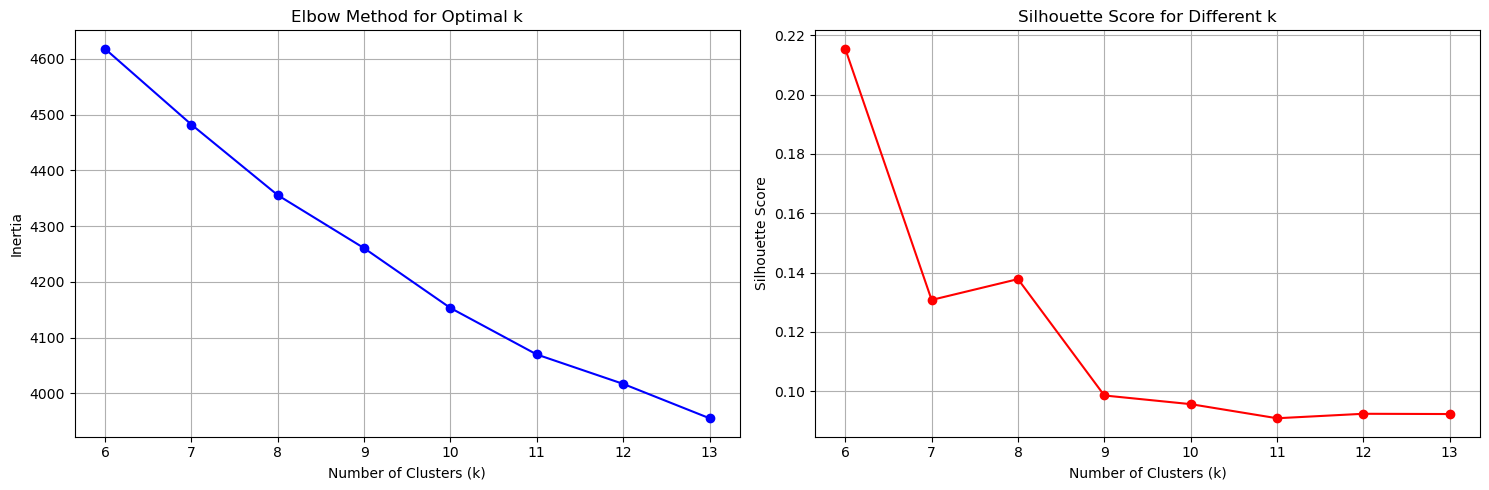

In [10]:
# Elbow method
print("Finding optimal number of clusters...")
inertias = []
silhouette_scores = []
k_range = range(6, 14)

for k in tqdm(k_range):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(embedding_matrix)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(embedding_matrix, kmeans.labels_))

# Plot elbow curve and silhouette scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(k_range, inertias, 'bo-')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method for Optimal k')
ax1.grid(True)

ax2.plot(k_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score for Different k')
ax2.grid(True)

plt.tight_layout()
plt.show()

8 possui a maior Silhouette score

além disso, está ao lado do ponto de "desaceleração" da inercia, em k=8

In [11]:
n_clusters = 8

In [12]:
### 

In [13]:
# Perform final clustering with specified number of clusters
print(f"Performing K-means clustering with {n_clusters} clusters...")
kmeans_final = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(embedding_matrix)

# Add cluster labels to dataframe
df_chats['cluster'] = cluster_labels

# Calculate silhouette score for final clustering
final_silhouette = silhouette_score(embedding_matrix, cluster_labels)
print(f"Final silhouette score: {final_silhouette:.3f}")


Performing K-means clustering with 8 clusters...
Final silhouette score: 0.138



Cluster Analysis:

Cluster 0 (5206 messages):
------------------------------
Sample messages:
  1. Não consigo acessar minha conta gov por que mudei de telefone 
#####################################...
  2. Preciso recuperar minha conta gov
##################################################
Olá! Você está ...
  3. Tirar o acesso em duas etapas 
##################################################
Olá! Você está no ...

Cluster 1 (1291 messages):
------------------------------
Sample messages:
  1. Gostaria de saber se eu tenho fundos perdidos no meu Gov
###########################################...
  2. Oi...
  3. Como consigo o Demolstrativo do meu Benefício de2024 para o Imposto de renda
#######################...

Cluster 2 (13657 messages):
------------------------------
Sample messages:
  1. Quero o acesso novamente 
##################################################
Olá! Você está no Chat ...
  2. Não consigo tirar foto da erro 
##################################################

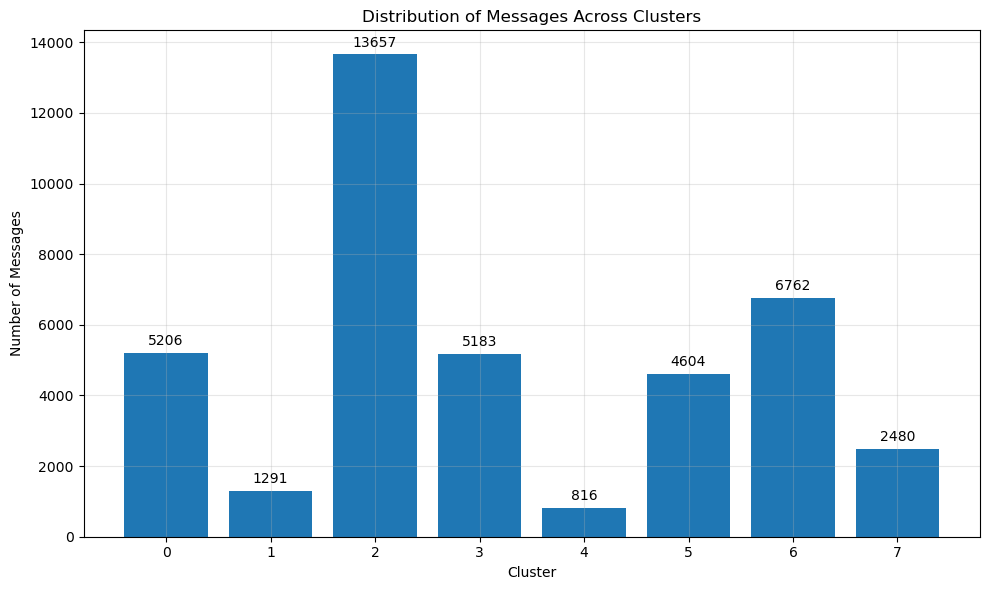

In [14]:
# Analyze clusters
print("\nCluster Analysis:")
print("="*50)

for i in range(n_clusters):
    cluster_texts = df_chats[df_chats['cluster'] == i]['content']
    print(f"\nCluster {i} ({len(cluster_texts)} messages):")
    print("-" * 30)
    
    # Get top terms for this cluster
    cluster_center = kmeans_final.cluster_centers_[i]
    top_indices = cluster_center.argsort()[-10:][::-1]
    
    # Show sample messages from this cluster
    sample_messages = cluster_texts.head(3).tolist()
    print("Sample messages:")
    for j, msg in enumerate(sample_messages, 1):
        print(f"  {j}. {msg[:100]}...")

# Create cluster distribution plot
plt.figure(figsize=(10, 6))
cluster_counts = Counter(cluster_labels)
clusters = list(cluster_counts.keys())
counts = list(cluster_counts.values())

plt.bar(clusters, counts)
plt.xlabel('Cluster')
plt.ylabel('Number of Messages')
plt.title('Distribution of Messages Across Clusters')
plt.xticks(clusters)
plt.grid(True, alpha=0.3)

for cluster_id, count in zip(clusters, counts):
    plt.text(cluster_id, count + max(counts) * 0.01, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Cluster visualization

In [15]:
from visualizations import create_3d_cluster_visualization, create_2d_comparison_plots, analyze_cluster_separation

In [16]:
df_chats[(df_chats['content'] == "1")]

Unnamed: 0                     conversation_uuid  \
1784610     1784610  f5729994-cda2-405b-897b-792d75cb18e2   
1572491     1572491  d83c51aa-ab0e-41c4-9413-ad2e944fa32a   
947389       947389  825741a0-6a0b-4e0b-919e-50e11a45ce41   
1312521     1312521  b4855162-b235-435e-8a98-f3c78cbfd75f   
1540699     1540699  d3ddc7bc-ca0b-4efc-9ea8-0932365453cc   
430207       430207  3b2f5967-439a-443a-92dc-4809793211df   

                                         name   author content  cluster  
1784610                         Fabio Camacho  CONTACT       1        1  
1572491  Alessandra coelho da Silva Oliveira   CONTACT       1        1  
947389                  ROBSON GARRRIDOCALDAS  CONTACT       1        1  
1312521                   neusa maria martins  CONTACT       1        1  
1540699              Edna Maria Soares Silva   CONTACT       1        1  
430207                 Reginaldo Mota Simões   CONTACT       1        1

In [17]:
# df_chats = df_chats.drop(df_chats[(df_chats['content'] == "1")].index)

Sampling 10000 points from 39999 total points for visualization...
Computing t-SNE 3D embedding...
Using IQR method for outlier detection...
   Dimension 0: removed 0 outliers (bounds: -38.35 to 39.62)
   Dimension 1: removed 0 outliers (bounds: -33.63 to 34.63)
   Dimension 2: removed 0 outliers (bounds: -34.90 to 35.63)
Total outliers removed: 0/10000 (0.0%)
Remaining points: 10000


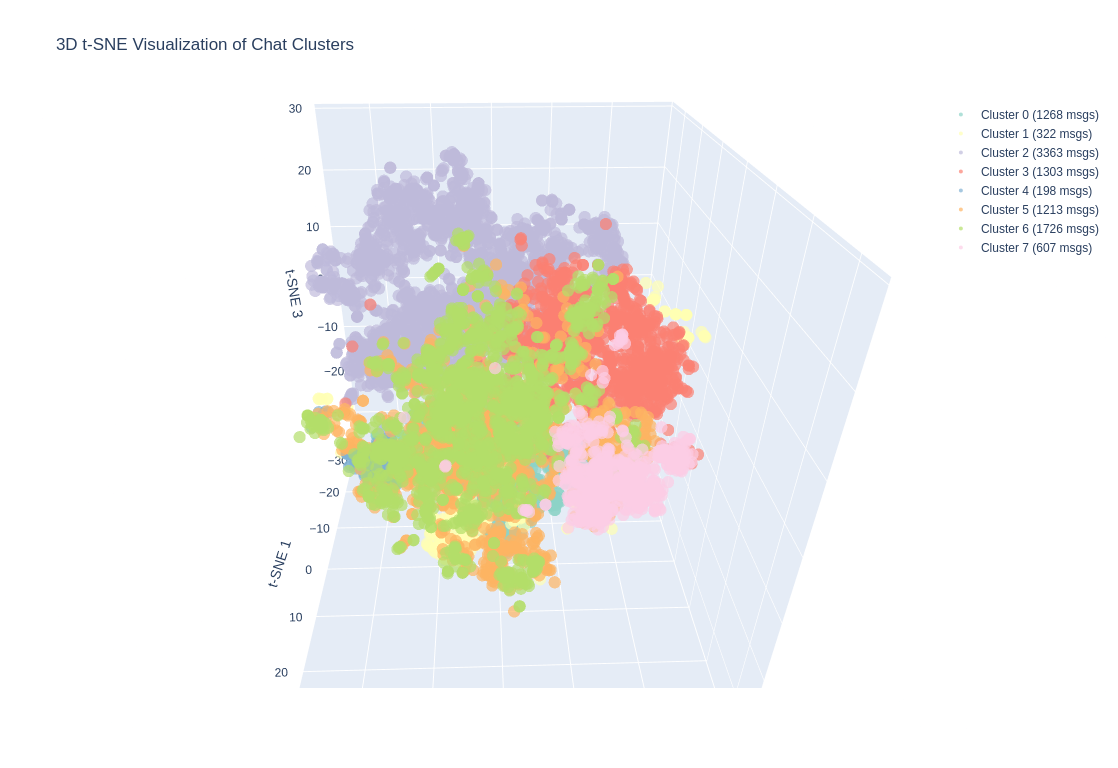

Computing PCA 3D embedding...


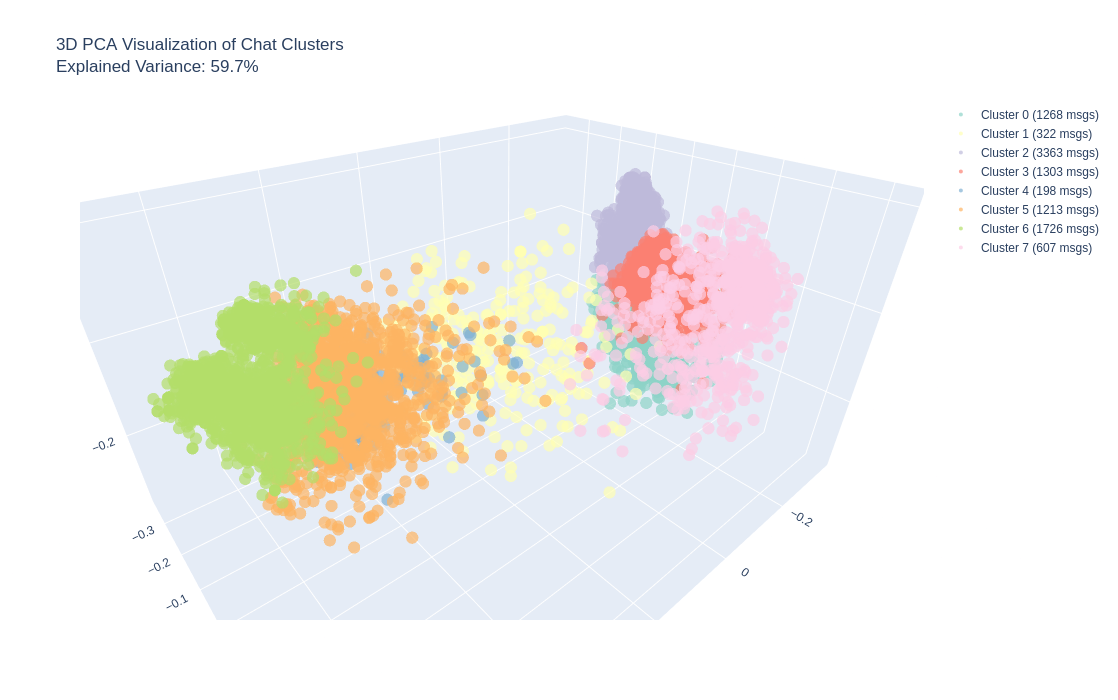

In [18]:
tsne_coords, pca_coords = create_3d_cluster_visualization(
    df_chats, embedding_matrix, method='both', sample_size=10000,
    use_embeddings=True
)

Computing 2D embeddings for comparison...


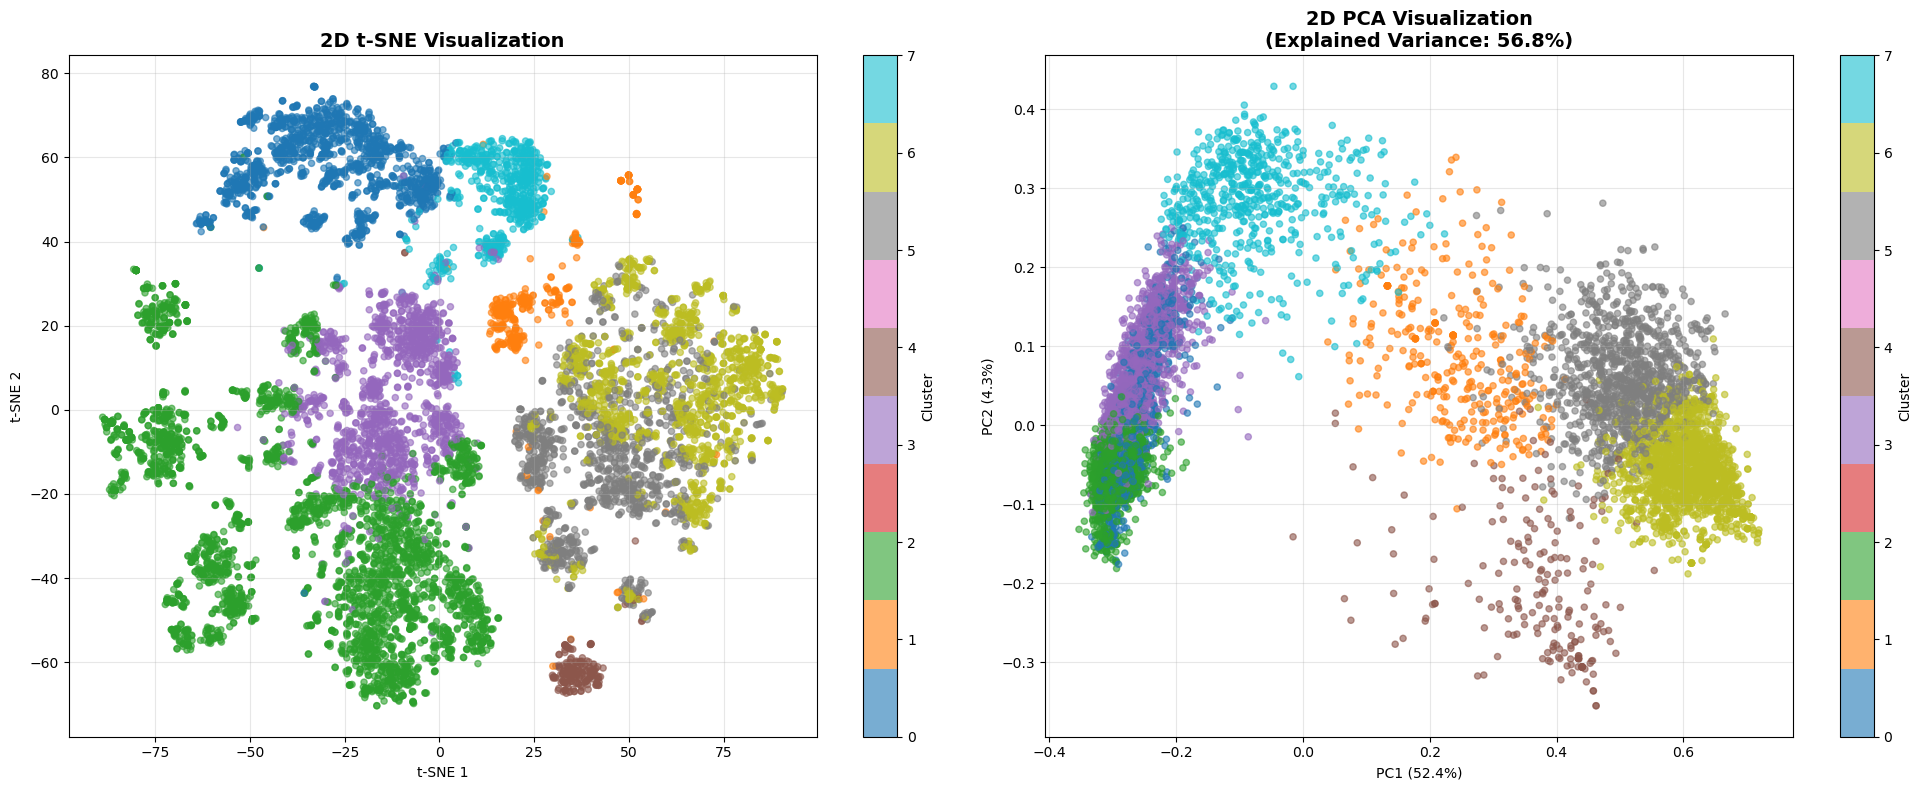

In [20]:
# Create 2D comparison plots
tsne_2d, pca_2d = create_2d_comparison_plots(df_chats, embedding_matrix, sample_size=10000, use_embeddings=True)
